In [1]:
# Visualization of activity difference between a classical neural network and a FGnet
# shows that FGNs are trainable over multiple layers
# shows that FGNs have less linear seperation of space

# this notebook showcases classic linear+tanh feedforward nets and full FGN nets

# you can try various: Network sizes, dropout probs, lambdas in the losses, different 2d data sets

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets as skdatasets
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle as shuffle_in_unison

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent                Fri Feb  5 20:59:46 2021  418.152.00
[0] GeForce RTX 2080 Ti | 85'C,  84 % |  6786 / 10989 MB | near(1271M) near(5504M)
[1] GeForce RTX 2080 Ti | 47'C,   0 % |    11 / 10989 MB |


In [6]:
# manualy set cuda device
# torch.cuda.set_device(1)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

CUDA Available:  False
Using device: cpu


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
total_num_samples = 5000

#  random moons
samples, labels = skdatasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)

# if desired, add another shape (classes stay the same)
# random concentric circles
samples2, labels2 = skdatasets.make_circles(n_samples=total_num_samples, noise=0.1, factor=0.4, shuffle=True)
samples = np.concatenate((samples, 2+samples2))
labels = np.concatenate((labels, labels2))
samples, labels = shuffle_in_unison(samples, labels)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

# normalize
scaler = StandardScaler()
scaler.fit(samples)
samples = scaler.transform(samples)


train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]


# # add noise?
# X1 = np.arange(-10.0, 10.01, 0.5)
# X1s, X2s = np.meshgrid(X1,X1)
# noise_samples = np.reshape(list(zip(X1s.flatten(),X2s.flatten())),(-1,2))
# noise_labels = np.array([np.random.choice([0,1]) for _ in range(len(noise_samples))])


# train_samples = np.concatenate((train_samples ,noise_samples),axis=0)
# train_labels = np.concatenate((train_labels ,noise_labels),axis=0)

# train_samples = noise_samples
# train_labels = noise_labels

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


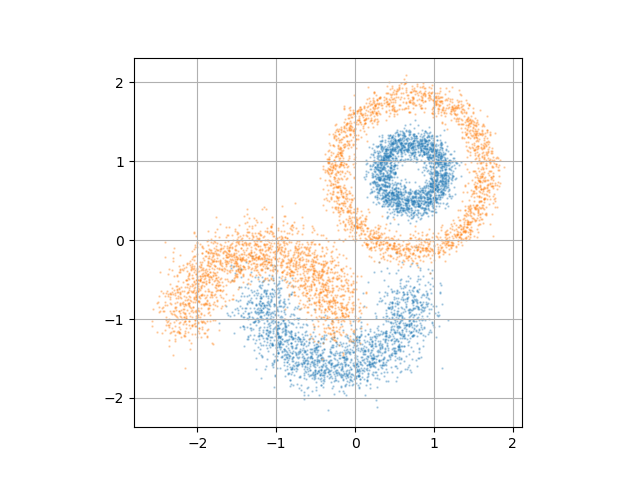

In [9]:
# 2D Check
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]

plt.scatter(samples_x_2, samples_y_2, alpha=0.3, s=0.5)
plt.scatter(samples_x_1, samples_y_1, alpha=0.3, s=0.5)

plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

In [10]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=5000, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, batch_size=1000, shuffle=True) # create your dataloader

In [11]:
### PART 1: classic feedforward net (linear with bias + tanh)

In [12]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

5e-05


In [13]:
# Initialize the classic network
hidden_layer_sizes = [32,16]
drop_p = 1/16

In [14]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p)
# classic_model.cuda()
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.0625, inplace=False)
    (1): Linear(in_features=2, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.0625, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.0625, inplace=False)
  )
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=16, out_features=2, bias=True)
)

In [15]:
# define model params to optimize
classic_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classic_model.parameters()), lr=0.003)
# classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()))

In [16]:
epochs = 100

In [17]:
# train the network for N epochs
print("# epochs:", epochs)
classic_train_res = fgnh.train(classic_model, my_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

# epochs: 100
Epoch 0 Train set - Average loss: 0.7231, Accuracy: 4752/8000 (59%)
Test set - Average loss: 0.6634, Accuracy: 1197/2000 (60%)
Epoch 1 Train set - Average loss: 0.6551, Accuracy: 5050/8000 (63%)
Test set - Average loss: 0.6505, Accuracy: 1411/2000 (71%)
Epoch 2 Train set - Average loss: 0.6342, Accuracy: 5030/8000 (63%)
Test set - Average loss: 0.6394, Accuracy: 1395/2000 (70%)
Epoch 3 Train set - Average loss: 0.6337, Accuracy: 4990/8000 (62%)
Test set - Average loss: 0.6309, Accuracy: 1405/2000 (70%)
Epoch 4 Train set - Average loss: 0.6215, Accuracy: 5113/8000 (64%)
Test set - Average loss: 0.6261, Accuracy: 1437/2000 (72%)
Epoch 5 Train set - Average loss: 0.6109, Accuracy: 5226/8000 (65%)
Test set - Average loss: 0.6263, Accuracy: 1407/2000 (70%)
Epoch 6 Train set - Average loss: 0.6079, Accuracy: 5334/8000 (67%)
Test set - Average loss: 0.6278, Accuracy: 1378/2000 (69%)
Epoch 7 Train set - Average loss: 0.6036, Accuracy: 5416/8000 (68%)
Test set - Average loss: 0.62

Epoch 64 Train set - Average loss: 0.3128, Accuracy: 6962/8000 (87%)
Test set - Average loss: 0.2540, Accuracy: 1773/2000 (89%)
Epoch 65 Train set - Average loss: 0.3091, Accuracy: 7029/8000 (88%)
Test set - Average loss: 0.2448, Accuracy: 1793/2000 (90%)
Epoch 66 Train set - Average loss: 0.3090, Accuracy: 6979/8000 (87%)
Test set - Average loss: 0.2411, Accuracy: 1802/2000 (90%)
Epoch 67 Train set - Average loss: 0.3031, Accuracy: 7028/8000 (88%)
Test set - Average loss: 0.2448, Accuracy: 1790/2000 (90%)
Epoch 68 Train set - Average loss: 0.2992, Accuracy: 7008/8000 (88%)
Test set - Average loss: 0.2396, Accuracy: 1796/2000 (90%)
Epoch 69 Train set - Average loss: 0.2979, Accuracy: 7049/8000 (88%)
Test set - Average loss: 0.2309, Accuracy: 1815/2000 (91%)
Epoch 70 Train set - Average loss: 0.2947, Accuracy: 7055/8000 (88%)
Test set - Average loss: 0.2304, Accuracy: 1807/2000 (90%)
Epoch 71 Train set - Average loss: 0.2927, Accuracy: 7054/8000 (88%)
Test set - Average loss: 0.2273, Ac

In [18]:
# test the statibility of the model (these numbers should be same as final lines above)
_ = fgnh.test(classic_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(classic_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1622, Accuracy: 7544/8000 (94%)
Test set - Average loss: 0.1659, Accuracy: 1896/2000 (95%)


/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_2D_heatmap.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.contourf(X1s, X2s, np.reshape(heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)


<IPython.core.display.Javascript object>


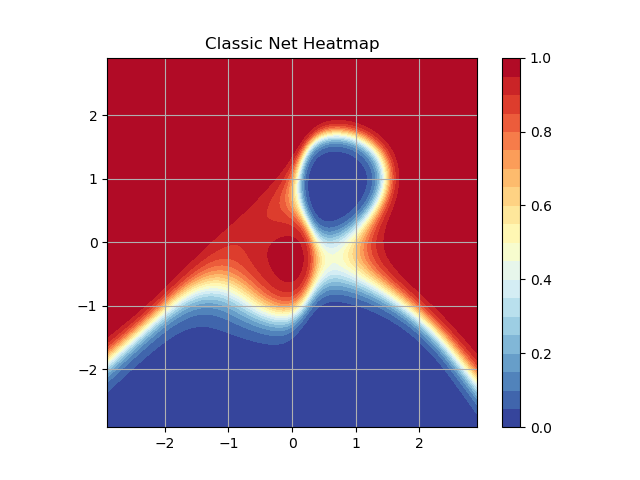

<IPython.core.display.Javascript object>


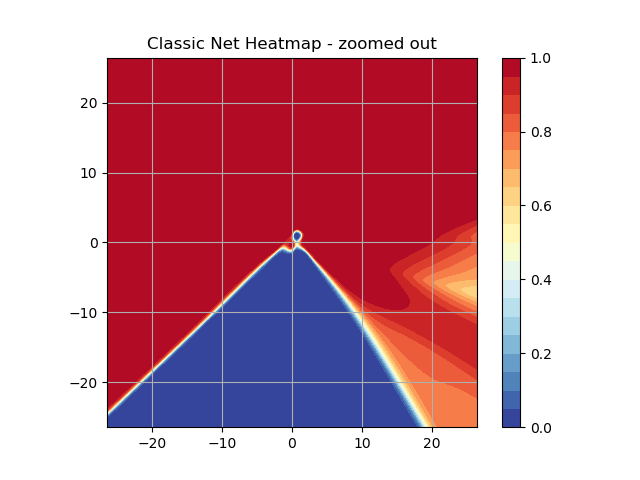

In [62]:
scale_max = np.max(np.abs(samples))

# fgnh.plot_2D_heatmap(classic_model, title="Classic Net Heatmap", scale=1.1*scale_max, show_data=my_dataloader)
fgnh.plot_2D_heatmap(classic_model, title="Classic Net Heatmap", scale=1.1*scale_max)
fgnh.plot_2D_heatmap(classic_model, title="Classic Net Heatmap - zoomed out", scale=10.0*scale_max)

In [20]:
### PART 2: fully FGN network

In [78]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 0.00001
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs loss", lmbda_sigs)


fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)


lambda for l2 loss 5e-05
lambda for sigs loss 1e-05


In [79]:
# fgn specific params
print("hidden layers:", hidden_layer_sizes)
# covariance type: sphere, diag or full
covar_type = 'diag'
print("covariance:", covar_type)
ordinal = float(0.8)
print("ordinal for norm:", ordinal)
non_lin = True
print("non linearity:", non_lin)
free_biases = True
print("free biases:", free_biases)

print("drop prob:", drop_p)


# Initialize the fgn network
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)
fgn_model.to(device)

hidden layers: [32, 16]
covariance: diag
ordinal for norm: 0.8
non linearity: True
free biases: True
drop prob: 0.0625


Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.0625, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.0625, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.0625, inplace=False)
  )
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [80]:
# define model params to optimize
fgn_optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.003)
# fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()))

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


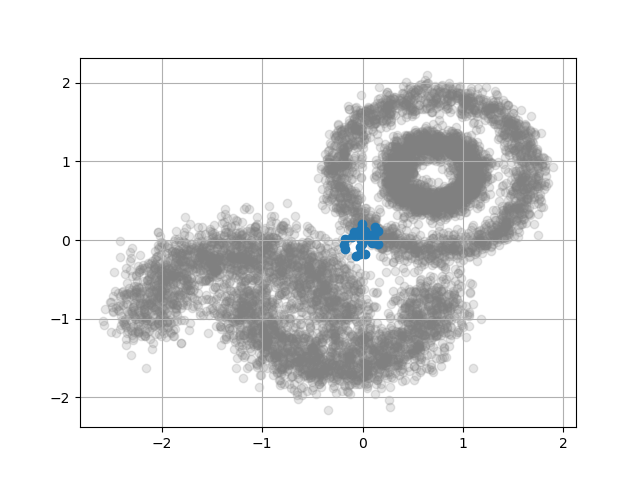

In [81]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

In [82]:
# set centers of first layer
fgn_model.set_first_layer_centers(my_dataloader)

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


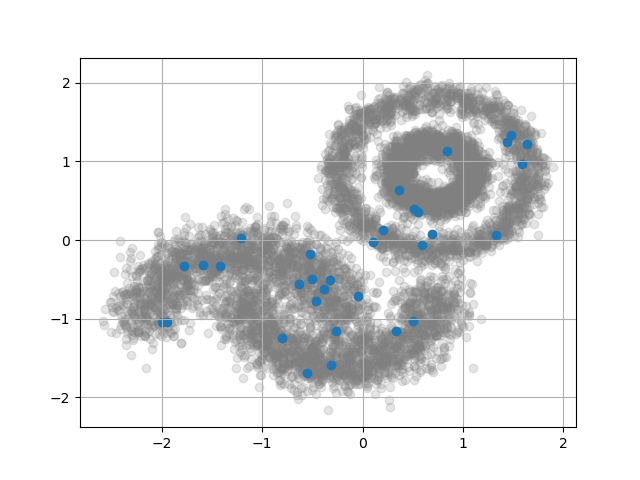

In [83]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

In [84]:
# model stats pre training
print(fgn_model)
print([p.size() for p in list(fgn_model.parameters())])
print([(n,p) for n,p in list(fgn_model.named_parameters()) if 'covar' in n ])
print("Training?", fgn_model.training) 
# print(fgn_model.state_dict())

print("losses")
print(fgnh.l2_loss(fgn_model))
print(fgnl.sigmas_loss(fgn_model))

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.0625, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.0625, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.0625, inplace=False)
  )
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)
[torch.Size([32, 2]), torch.Size([32]), torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32]), torch.Size([32]), torch.Size([16, 32]), torch.Size([16]), torch.Size([16, 32]), torch.Size([16, 32]), torch.Size([16]), torch.Size([16]), torch.Size([2]), torch.Size([2]), torch.Size([2, 16]), torch.Size([2]), torch.Size([2, 16]), torch.Size([2, 16])]
[('hidden_layers.1.inv_covars', Parameter containing:
tensor([[1.6116, 1.8485],
        [1.9212, 1.7114],
        [1.7953, 1.5045],
     

In [85]:
# train the network for N epochs
epochs = 100
fgn_train_res = fgnh.train(fgn_model, my_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.6879, Accuracy: 4147/8000 (52%)
Test set - Average loss: 0.6921, Accuracy: 1036/2000 (52%)
Epoch 1 Train set - Average loss: 0.6691, Accuracy: 4619/8000 (58%)
Test set - Average loss: 0.6911, Accuracy: 1036/2000 (52%)
Epoch 2 Train set - Average loss: 0.6505, Accuracy: 5197/8000 (65%)
Test set - Average loss: 0.6897, Accuracy: 1036/2000 (52%)
Epoch 3 Train set - Average loss: 0.6303, Accuracy: 5988/8000 (75%)
Test set - Average loss: 0.6874, Accuracy: 1038/2000 (52%)
Epoch 4 Train set - Average loss: 0.6100, Accuracy: 6353/8000 (79%)
Test set - Average loss: 0.6844, Accuracy: 1069/2000 (53%)
Epoch 5 Train set - Average loss: 0.5891, Accuracy: 6427/8000 (80%)
Test set - Average loss: 0.6802, Accuracy: 1121/2000 (56%)
Epoch 6 Train set - Average loss: 0.5672, Accuracy: 6348/8000 (79%)
Test set - Average loss: 0.6745, Accuracy: 1206/2000 (60%)
Epoch 7 Train set - Average loss: 0.5442, Accuracy: 6373/8000 (80%)
Test set - Average loss: 0.6672, Accuracy: 

Epoch 65 Train set - Average loss: 0.1201, Accuracy: 7629/8000 (95%)
Test set - Average loss: 0.0778, Accuracy: 1955/2000 (98%)
Epoch 66 Train set - Average loss: 0.1199, Accuracy: 7630/8000 (95%)
Test set - Average loss: 0.0795, Accuracy: 1954/2000 (98%)
Epoch 67 Train set - Average loss: 0.1247, Accuracy: 7604/8000 (95%)
Test set - Average loss: 0.0830, Accuracy: 1960/2000 (98%)
Epoch 68 Train set - Average loss: 0.1157, Accuracy: 7671/8000 (96%)
Test set - Average loss: 0.0850, Accuracy: 1958/2000 (98%)
Epoch 69 Train set - Average loss: 0.1231, Accuracy: 7603/8000 (95%)
Test set - Average loss: 0.0851, Accuracy: 1956/2000 (98%)
Epoch 70 Train set - Average loss: 0.1199, Accuracy: 7618/8000 (95%)
Test set - Average loss: 0.0835, Accuracy: 1957/2000 (98%)
Epoch 71 Train set - Average loss: 0.1179, Accuracy: 7631/8000 (95%)
Test set - Average loss: 0.0831, Accuracy: 1956/2000 (98%)
Epoch 72 Train set - Average loss: 0.1207, Accuracy: 7602/8000 (95%)
Test set - Average loss: 0.0791, Ac

In [86]:
# model stats post training
print(fgn_model)
print([p.size() for p in list(fgn_model.parameters())])
print([(n,p) for n,p in list(fgn_model.named_parameters()) if 'covar' in n ])
print("Training?", fgn_model.training) 
# print(fgn_model.state_dict())

print("losses")
print(fgnh.l2_loss(fgn_model))
print(fgnl.sigmas_loss(fgn_model))

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.0625, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.0625, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.0625, inplace=False)
  )
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)
[torch.Size([32, 2]), torch.Size([32]), torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32]), torch.Size([32]), torch.Size([16, 32]), torch.Size([16]), torch.Size([16, 32]), torch.Size([16, 32]), torch.Size([16]), torch.Size([16]), torch.Size([2]), torch.Size([2]), torch.Size([2, 16]), torch.Size([2]), torch.Size([2, 16]), torch.Size([2, 16])]
[('hidden_layers.1.inv_covars', Parameter containing:
tensor([[1.4534, 1.7778],
        [1.8247, 1.4936],
        [2.1000, 1.2335],
     

In [87]:
# test the statibility of the model (these numbers should be close as final lines above, depending)

# print("Random Eval OFF")
fgn_model.set_random_eval(False)
_ = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# print("Random Eval ON")
# fgn_model.set_random_eval(True)
# _ = fgnh.test(fgn_model, my_dataloader,
#                         fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# _ = fgnh.test(fgn_model, my_test_dataloader,
#                         fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0715, Accuracy: 7816/8000 (98%)
Test set - Average loss: 0.0759, Accuracy: 1958/2000 (98%)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


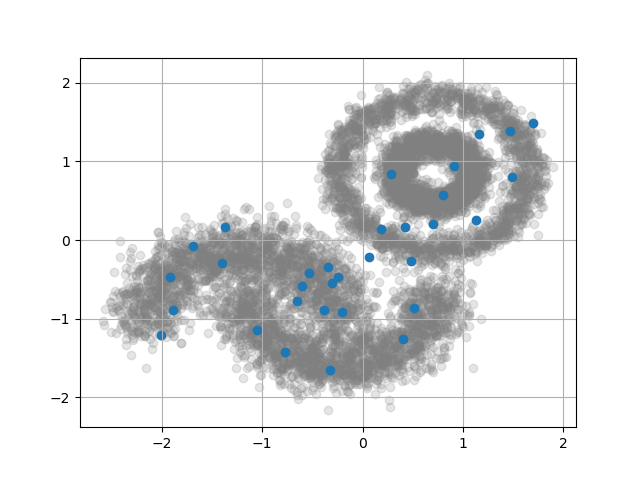

In [88]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_2D_heatmap.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.contourf(X1s, X2s, np.reshape(heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)


<IPython.core.display.Javascript object>


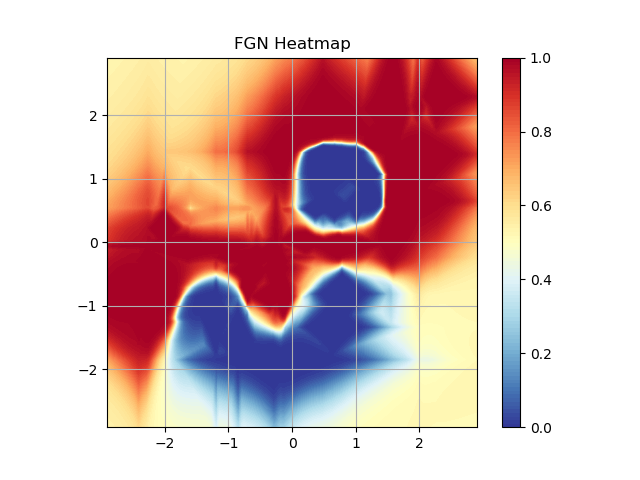

<IPython.core.display.Javascript object>


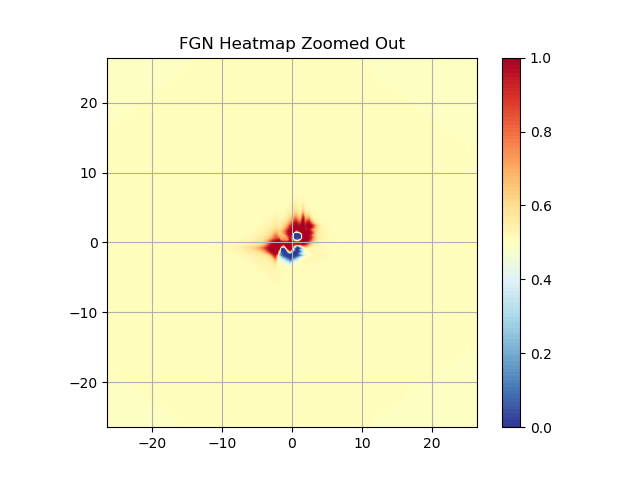

<IPython.core.display.Javascript object>


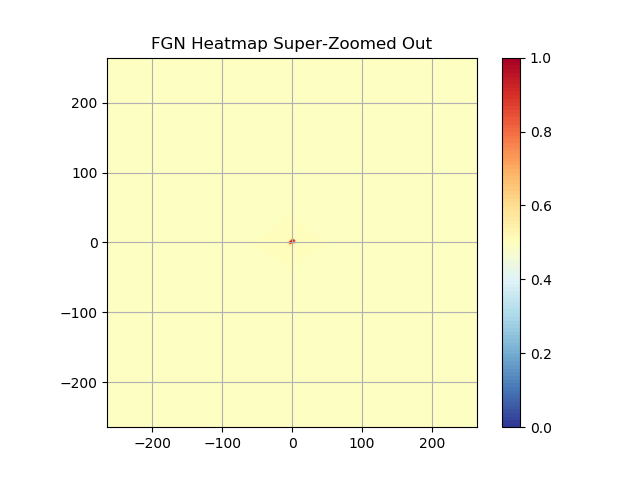

In [123]:
# fgn_model.set_random_eval(False)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap", scale=1.1*scale_max, show_data=False)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Zoomed Out", scale=10.0*scale_max)
r = fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Super-Zoomed Out", scale=100.0*scale_max)

In [124]:
r

array([[ 0., -0.],
       [ 0., -0.],
       [ 0., -0.],
       ...,
       [ 0., -0.],
       [ 0., -0.],
       [ 0., -0.]], dtype=float32)

In [90]:
# # compute predictions for heatmap with random eval
# fgn_model.set_random_eval(True)
# fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap - Random ON")
# fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Zoomed Out - Random ON", scale=100.0)
# fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Super-Zoomed Out - Random ON", scale=10000.0)

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


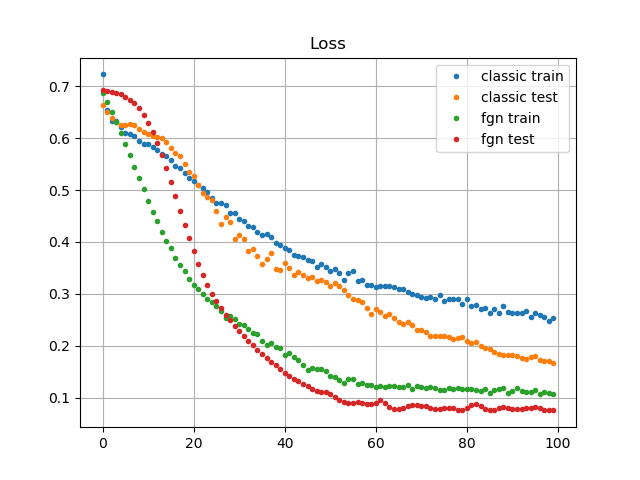

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


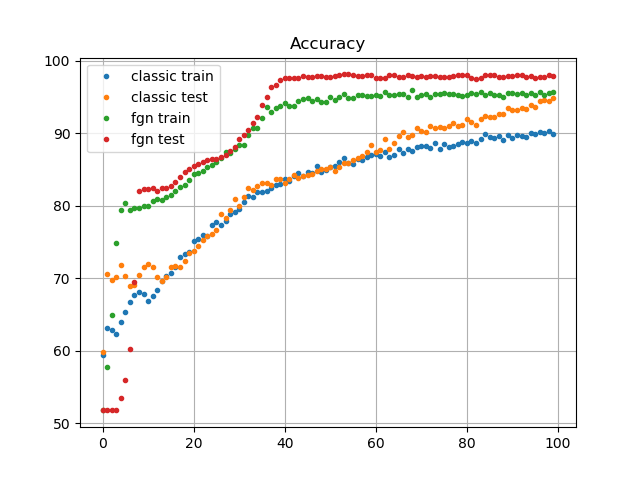

In [91]:
# acc and loss hist
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [92]:
### plot some FGN param movement during training

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


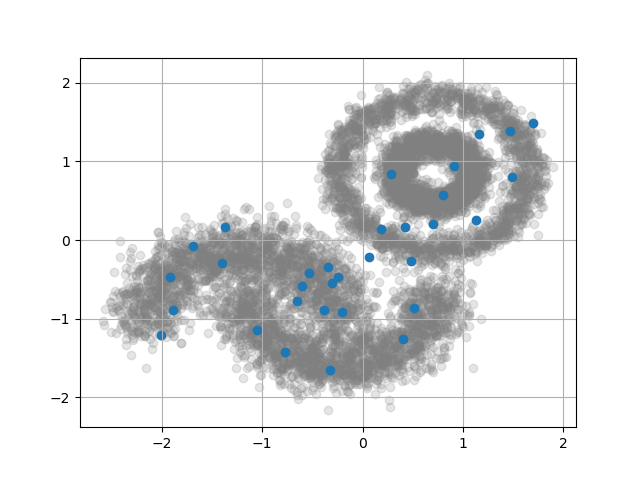

In [93]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_centers_histories.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplot(2,1,idx+1)


<IPython.core.display.Javascript object>


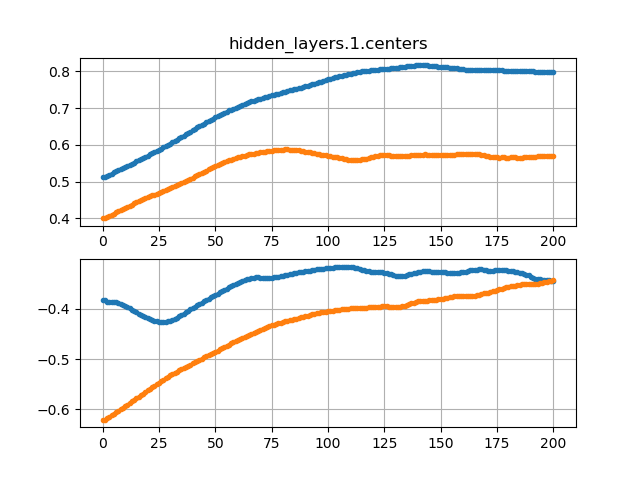

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_centers_histories.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplot(2,1,idx+1)


<IPython.core.display.Javascript object>


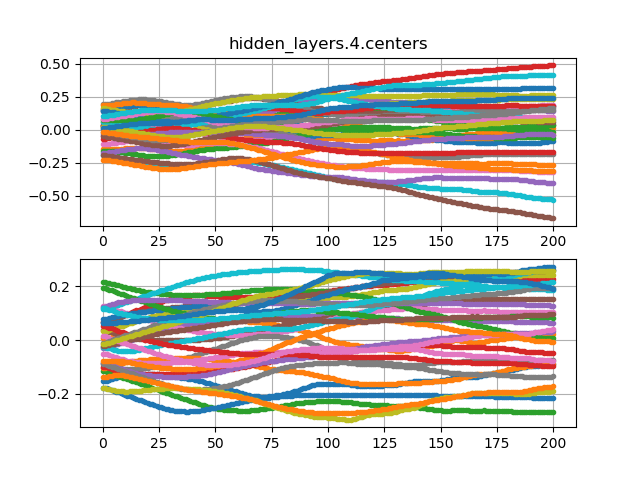

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_centers_histories.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplot(2,1,idx+1)


<IPython.core.display.Javascript object>


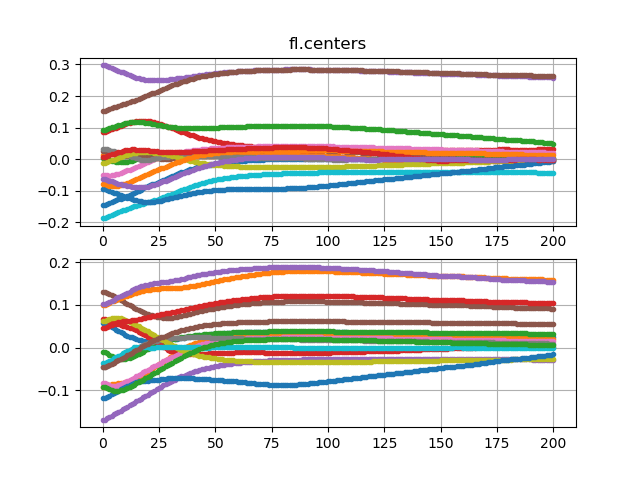

In [94]:
# plot centers history for only some hidden layer neuron
fgnl.plot_centers_histories(fgn_train_res['histories'])

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(x)


<IPython.core.display.Javascript object>


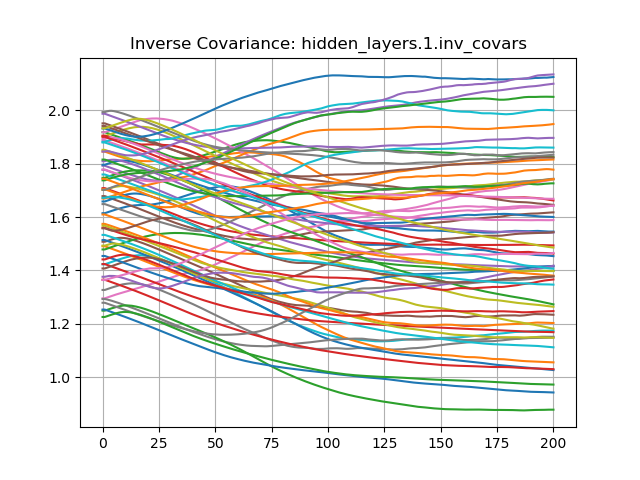

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(x)


<IPython.core.display.Javascript object>


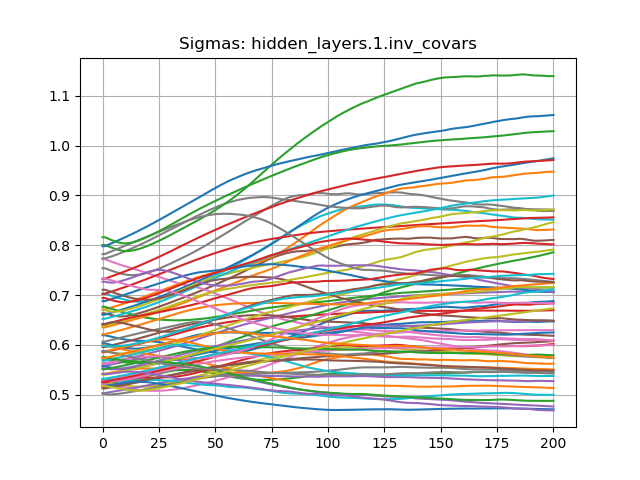

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(x)


<IPython.core.display.Javascript object>


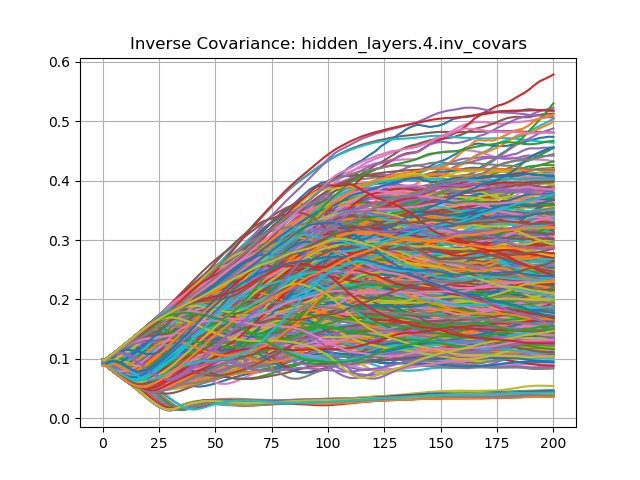

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(x)


<IPython.core.display.Javascript object>


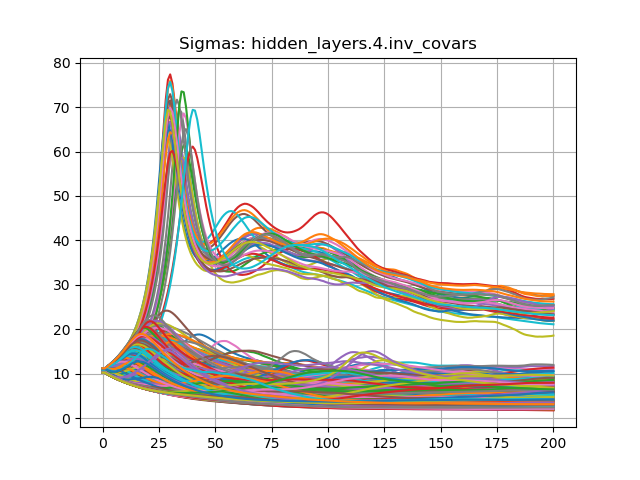

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(x)


<IPython.core.display.Javascript object>


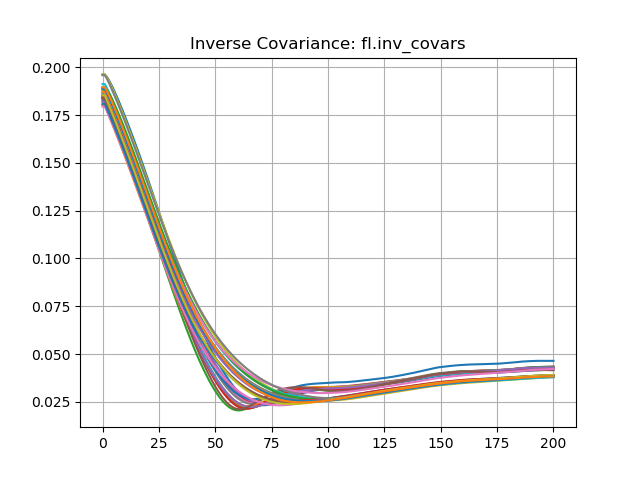

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(x)


<IPython.core.display.Javascript object>


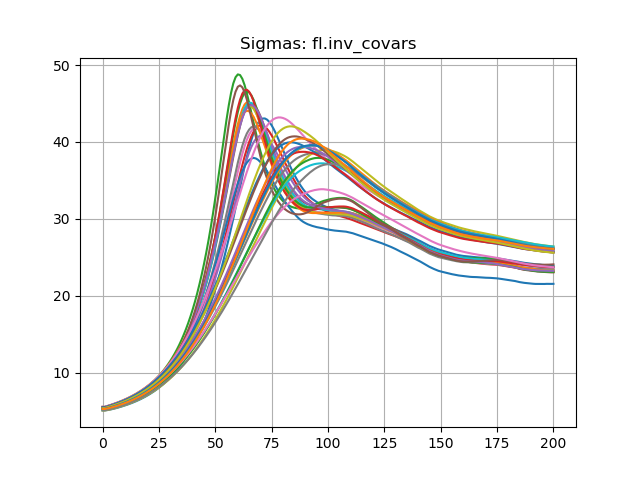

In [95]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
fgnl.plot_sigmas_histories(fgn_train_res['histories'], covar_type=fgn_model.covar_type)

In [96]:
# ### what about a converted net
# # Initialize the fgn network
# print("hidden layers:", hidden_l_nums)
# print("drop prob:", drop_p)
# converted_fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [97]:
# fgnl.convert_classic_to_fgn(classic_model, converted_fgn_model)

In [98]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [99]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [100]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])


# plt.grid(True)
# plt.show()

In [101]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [102]:
# adjust sigmas

In [103]:
# def adjust_sigma_pred_func(fgn_model, dataloader, pred_func, verbose):
    
#     ###
#     # adjusts the sigmas of the given fgn model so that the pred accuracy over the dataset is max
#     ###
    
#     # best pred acc yet
#     fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#     best_pred = fgn_test_res['test_accuracy']
#     # best sigma multiplier yet
#     best_sig_mult = 1.0
#     # lower bound for sigma mult
#     lower_bound = 0.0
#     # uper bound for sigma
#     upper_bound = float('Inf')
    
#     # max number of values to test
#     max_iter = 25
    
#     # first double sigmas until performance decreases
#     for ite in range(max_iter):
#         # new val to test
#         cur_sig_mult = 2.0*best_sig_mult
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred > best_pred:
#             if verbose: print("new best during doubling")
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
#             # increase lower bound
#             lower_bound = cur_sig_mult
#         else:
#             # new upper bound
#             upper_bound = cur_sig_mult
#             # and exit loop
#             break
            
            
#     # next half sigmas until performance decreases
#     for ite in range(max_iter):
#         # new val to test
#         cur_sig_mult = 0.5*best_sig_mult
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred >= (1.0-1e-3)*best_pred:
#             if verbose: print("new best during halfing")
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
#             # new upper bound
#             upper_bound = cur_sig_mult
#         else:
#             # increase lower bound
#             lower_bound = cur_sig_mult
#             # and exit loop
#             break
    
#     # now that we have a real bounds, search by dichotomie
#     for ite in range(max_iter):

#         # new val to test
#         cur_sig_mult = 0.5*(upper_bound+lower_bound)
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred >= (1.0-1e-3)*best_pred:
#             if verbose: print("new best during dicho")
#             # new low bound
#             if cur_sig_mult > best_sig_mult:
#                 lower_bound = cur_sig_mult
#             # new upper bound
#             else:
#                 upper_bound = cur_sig_mult
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
                
#         else:
#             # new low bound
#             if cur_sig_mult < best_sig_mult:
#                 lower_bound = cur_sig_mult
#             # new upper bound
#             else:
#                 upper_bound = cur_sig_mult
            
#     # apply best mult
#     if verbose: print("best multiplier:", best_sig_mult)
#     for p in fgn_model.modules():
#         if isinstance(p, fgnl.FGN_layer):
#             p.sigmas = torch.nn.Parameter(p.sigmas*best_sig_mult)
            
#     return None

In [104]:
# adjust_sigma_pred_func(converted_fgn_model, my_dataloader, fgnh.cross_ent_pred_accuracy, verbose=True)

In [105]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [106]:
## post adjusting heatmap

In [107]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [108]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])

# plt.grid(True)
# plt.show()

In [109]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [110]:
# next idea: use grad descent to adjust sigmas and centers 

In [111]:
# for p in converted_fgn_model.named_parameters():
#     if 'weights' in p[0]:
#         print(p[1])

In [112]:
# # converted_fgn_sigmas_optimizer = optim.RMSprop([p[1] for p in converted_fgn_model.named_parameters()
# #                                       if p[1].requires_grad and ('censdfsdfsdfters' in p[0] or 'sigmas' in p[0])], 
# #                                      momentum=0.5)

# # converted_fgn_sigmas_optimizer = optim.RMSprop(filter(lambda p: (p[1].requires_grad),
# #                                                                  converted_fgn_model.named_parameters()),momentum=0.5)

# converted_fgn_sigmas_optimizer = optim.RMSprop([p[1] for p in converted_fgn_model.named_parameters()
#                                       if (p[1].requires_grad and 
#                                           (('weight' in p[0] and not 'weights' in p[0]) or 'bias' in p[0] 
#                                            or 'sigmas' in p[0] 
#                                            or 'centers'in p[0]))], 
#                                      momentum=0.5)

In [113]:
# converted_fgn_train_res = fgnh.train(converted_fgn_model, my_dataloader, 
#                              fgn_cross_ent_loss, converted_fgn_sigmas_optimizer, epochs, save_hist=2, verbose=True, 
#                              pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

In [114]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [115]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])

# plt.grid(True)
# plt.show()

In [116]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [117]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [118]:
# for p in converted_fgn_model.named_parameters():
#     if 'weights' in p[0]:
#         print(p[1])